In [1]:
import warnings

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import random
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D, Reshape, MaxPooling1D, Lambda
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.engine.topology import Layer
import tensorflow as tf
from keras import backend as K

import json

from bs4 import BeautifulSoup
import requests
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS


# Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='e6ff82a6418a4191a5b3a95622faf5dd', client_secret='a37b632dc07d4136902fa95ec56281d3')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Genius
Genius_TOKEN = 'C2ow8dBpT2W5ORhiqaiz8ht8zLs9UzjFJQS5fwsmkRwWZyj8Wi1dA37FXYjScYuu'

import re

pd.set_option('display.width', 1500) 
pd.set_option('display.max_columns', 200)

Using TensorFlow backend.


# Preprocessing

## Load data and convert to arrays based on playlists

- Load pre-processed data as a DataFrame. Each row corresponds to a track.

In [2]:
playlists_df = pd.read_pickle('../../Data Scraping/playlists_df_clean.pkl')

- Check the data attributes and size:

In [3]:
display(playlists_df.columns)
display(playlists_df.head())
display(playlists_df.describe())
print(f'Shape of playlists_df : {playlists_df.shape}')

Index(['acousticness', 'country', 'danceability', 'disco', 'duration_ms', 'edm', 'electronic', 'emo', 'energy', 'folk',
       ...
       'lyric_language_spanish', 'lyric_language_korean', 'lyric_language_french', 'lyric_language_tagalog', 'lyric_language_german', 'lyric_language_portuguese', 'lyric_language_russian', 'lyric_language_italian', 'track_name_language_english', 'track_name_language_spanish'], dtype='object', length=114)

,acousticness,country,danceability,disco,duration_ms,edm,electronic,emo,energy,folk,funk,gospel,house,instrumentalness,k-pop,key,latin,liveness,loudness,metal,metalcore,mode,pid,pop,popularity,pos,punk,reggaeton,related_artist_n,rock,rockabilly,singer-songwriter,soul,speechiness,tempo,time_signature,top_track_n,valence,year,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9,track_name_language_reliable,lyric_language_reliable,NLP_sentiment,NLP_personality_extraversion,NLP_personality_openness,NLP_personality_agreeableness,NLP_personality_conscientiousness,from_genius,from_lyrics_wiki,NLP_emotion_anger,NLP_emotion_fear,NLP_emotion_joy,NLP_emotion_sadness,NLP_emotion_surprise,trial_0.0,trial_1.0,trial_2.0,trial_3.0,try_idx_0.0,try_idx_1.0,try_idx_2.0,try_idx_3.0,try_idx_4.0,try_idx_5.0,NLP_topic_poetry,NLP_topic_music,NLP_topic_drugs,NLP_topic_romance,NLP_topic_parenting,NLP_topic_running,NLP_topic_entertainment_news,NLP_topic_military,NLP_topic_fashion,NLP_topic_cricket,NLP_topic_swimming,NLP_topic_surfing,NLP_topic_guns,NLP_topic_biology,NLP_topic_personal,NLP_topic_history,NLP_topic_books,NLP_topic_sailing,NLP_topic_bicycling,NLP_topic_business,NLP_topic_film,NLP_topic_fiction,NLP_topic_golf,NLP_topic_christianity,NLP_topic_comics,NLP_topic_nostalgia,NLP_topic_weight_training,NLP_topic_astronomy,NLP_topic_art,NLP_topic_hunting,lyric_language_english,lyric_language_spanish,lyric_language_korean,lyric_language_french,lyric_language_tagalog,lyric_language_german,lyric_language_portuguese,lyric_language_russian,lyric_language_italian,track_name_language_english,track_name_language_spanish
0,0.011400,0.0,0.775,0.0,351640,0.0,0.0,0.0,0.828,0.0,0.0,0.0,0.0,0.367000,0.0,11.0,0.0,0.2460,-7.511,0.0,0.0,0.0,391407,0.0,8.0,0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0503,108.016,4.0,7.0,0.531,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.921551,0.545398,0.455326,0.594833,0.475259,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0.094400,0.0,0.591,0.0,213333,0.0,0.0,0.0,0.892,0.0,0.0,0.0,0.0,0.000000,0.0,8.0,0.0,0.1130,-6.114,0.0,0.0,0.0,391407,0.0,47.0,1,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.2930,89.849,4.0,10.0,0.712,2012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.927271,0.573924,0.500366,0.617451,0.423998,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0.312000,0.0,0.496,0.0,309346,0.0,0.0,0.0,0.531,0.0,0.0,0.0,0.0,0.009010,0.0,0.0,0.0,0.1130,-9.889,0.0,0.0,0.0,391407,0.0,15.0,2,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0325,119.159,4.0,10.0,0.507,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.352308,0.532170,0.433947,0.650911,0.457791,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.000029,0.0,0.420,0.0,286466,0.0,0.0,0.0,0.914,0.0,0.0,0.0,0.0,0.028200,0.0,6.0,0.0,0.2200,-4.322,0.0,0.0,0.0,391407,0.0,55.0,3,0.0,0.0,20.0,1.0,0.0,0.0,0.0,0.0431,170.199,4.0,10.0,0.301,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.975505,0.522853,0.438368,0.676775,0.484940,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0.024500,0.0,0.633,0.0,196848,0.0,0.0,0.0,0.881,0.0,0.0,0.0,0.0,0.000147,0.0,1.0,0.0,0.0474,-5.570,0.0,0.0,0.0,391407,0.0,54.0,4,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.1540,87.920,4.0,10.0,0.622,2014.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.983508,0.516442,0.353284,0.735746,0.483784,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,acousticness,country,danceability,disco,duration_ms,edm,electronic,emo,energy,folk,funk,gospel,house,instrumentalness,k-pop,key,latin,liveness,loudness,metal,metalcore,mode,pid,pop,popularity,pos,punk,reggaeton,related_artist_n,rock,rockabilly,singer-songwriter,soul,speechiness,tempo,time_signature,top_track_n,valence,year,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9,track_name_language_reliable,lyric_language_reliable,NLP_sentiment,NLP_personality_extraversion,NLP_personality_openness,NLP_personality_agreeableness,NLP_personality_conscientiousness,from_genius,from_lyrics_wiki,NLP_emotion_anger,NLP_emotion_fear,NLP_emotion_joy,NLP_emotion_sadness,NLP_emotion_surprise,trial_0.0,trial_1.0,trial_2.0,trial_3.0,try_idx_0.0,try_idx_1.0,try_idx_2.0,try_idx_3.0,try_idx_4.0,try_idx_5.0,NLP_topic_poetry,NLP_topic_music,NLP_topic_drugs,NLP_topic_romance,NLP_topic_parenting,NLP_topic_running,NLP_topic_entertainment_news,NLP_topic_military,NLP_topic_fashion,NLP_topic_cricket,NLP_topic_swimming,NLP_topic_surfing,NLP_topic_guns,NLP_topic_biology,NLP_topic_personal,NLP_topic_history,NLP_topic_books,NLP_topic_sailing,NLP_topic_bicycling,NLP_topic_business,NLP_topic_film,NLP_topic_fiction,NLP_topic_golf,NLP_topic_christianity,NLP_topic_comics,NLP_topic_nostalgia,NLP_topic_weight_training,NLP_topic_astronomy,NLP_topic_art,NLP_topic_hunting,lyric_language_english,lyric_language_spanish,lyric_language_korean,lyric_language_french,lyric_language_tagalog,lyric_language_german,lyric_language_portuguese,lyric_language_russian,lyric_language_italian,track_name_language_english,track_name_language_spanish
count,55000.000000,55000.000000,55000.000000,55000.000000,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,0.257011,0.031745,0.596193,0.008545,2.350665e+05,0.045982,0.007636,0.015345,0.632996,0.011345,0.015473,0.003509,0.009891,0.074761,0.004673,5.206436,0.040345,0.190331,-7.525920,0.004564,0.005182,0.653818,497957.939000,0.291127,41.108036,27.000000,0.007600,0.020982,19.883436,0.076909,0.004891,0.013527,0.015945,0.091508,121.494737,3.930564,9.851164,0.483090,2007.687376,0.112091,0.060345,0.042509,0.034800,0.027182,0.021364,0.020418,0.017036,0.014873,0.014000,0.543818,0.938891,0.674081,0.563834,0.431771,0.665134,0.456555,0.965673,0.002891,0.069982,0.041545,0.170145,0.543400,0.039400,0.871709,0.023909,0.068836,0.004109,0.880764,0.084109,0.000436,0.000236,0.000109,0.002909,0.306564,0.215273,0.046527,0.042582,0.031891,0.016855,0.013964,0.012073,0.008927,0.005909,0.005691,0.005600,0.005382,0.0

Shape of playlists_df : (55000, 114)


- Convert the DataFrame to the arrays of playlists, of which the size is (#playlists, #tracks per playlist, #features).
- Remove the pid and pos as these may contain information we want to predict.

In [4]:
random.seed(a=99)
np.random.seed(99)

feature_lists = playlists_df.columns[(playlists_df.columns!="pid")]
tracks_per_playlist = 55

pid_list = np.unique(playlists_df['pid'])

for i, pid in enumerate(pid_list):
    pl = playlists_df.loc[playlists_df['pid']==pid]
    pl = pl.sort_values('pos')
    if pl.shape[0] >= tracks_per_playlist:
        pl_array = pl[feature_lists].values[:tracks_per_playlist].reshape([1,tracks_per_playlist,len(feature_lists)])
        if i == 0:
            playlists_array = pl_array
        else:
            playlists_array = np.append(playlists_array, pl_array, axis=0)

print(f'Shape of playlists_array : {playlists_array.shape}')


Shape of playlists_array : (1000, 55, 113)


- Split the train-test set. As the number of playlist is big enough and there is no clear metric to stratify, we simply randomly sample playlists from the data base.

In [5]:
test_size = .2

playlist_num = len(playlists_array)
test_idx = random.sample(range(playlist_num),int(playlist_num*test_size))
train_idx = [i for i in range(playlist_num) if i not in test_idx]

pl_train_array = playlists_array[train_idx]
pl_test_array = playlists_array[test_idx]
print(f'Shape of pl_train_array : {pl_train_array.shape}')
print(f'Shape of pl_test_array : {pl_test_array.shape}')

Shape of pl_train_array : (800, 55, 113)
Shape of pl_test_array : (200, 55, 113)


## Standardize the data

- Standardize the data using StandardScaler:

In [6]:
tr_train_df = pd.DataFrame()
tr_test_df = pd.DataFrame()
tr_train_array = pl_train_array.reshape([len(pl_train_array)*tracks_per_playlist,len(feature_lists)])
tr_test_array = pl_test_array.reshape([len(pl_test_array)*tracks_per_playlist,len(feature_lists)])
for i, f in enumerate(feature_lists):
    tr_train_df[f] = tr_train_array[:,i]
    tr_test_df[f] = tr_test_array[:,i]

In [7]:
scaler = StandardScaler().fit(tr_train_df)

In [8]:
def scale_columns(df_arg, scaler_arg, col_arg: list):
    '''
        input
            df_arg : data_frame
            scaler_arg : StandardScaler object containing the information (min, max) of columns of training set
            col_arg : a list of columns
        output
            scaled_df : standardized data_frame
    '''
    # copy the dataframe in order not to affect to original data frame 
    scaled_df = df_arg.copy()
    scaled_df[col_arg] = scaler_arg.transform(df_arg[col_arg])
    
    return scaled_df

In [9]:
scaled_tr_train_df = scale_columns(tr_train_df, scaler, feature_lists)
scaled_tr_test_df = scale_columns(tr_test_df, scaler, feature_lists)

- Convert the DataFrame back to arrays of playlists. Check the size and values:

In [10]:
scaled_pl_train_array = scaled_tr_train_df.values.reshape([len(pl_train_array),tracks_per_playlist,len(feature_lists),1])
scaled_pl_test_array = scaled_tr_test_df.values.reshape([len(pl_test_array),tracks_per_playlist,len(feature_lists),1])
print(f'Shape of scaled_pl_train_array : {scaled_pl_train_array.shape}')
print(f'Shape of scaled_pl_test_array : {scaled_pl_test_array.shape}')


Shape of scaled_pl_train_array : (800, 55, 113, 1)
Shape of scaled_pl_test_array : (200, 55, 113, 1)


In [11]:
scaled_tr_train_df.describe()

,acousticness,country,danceability,disco,duration_ms,edm,electronic,emo,energy,folk,funk,gospel,house,instrumentalness,k-pop,key,latin,liveness,loudness,metal,metalcore,mode,pop,popularity,pos,punk,reggaeton,related_artist_n,rock,rockabilly,singer-songwriter,soul,speechiness,tempo,time_signature,top_track_n,valence,year,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9,track_name_language_reliable,lyric_language_reliable,NLP_sentiment,NLP_personality_extraversion,NLP_personality_openness,NLP_personality_agreeableness,NLP_personality_conscientiousness,from_genius,from_lyrics_wiki,NLP_emotion_anger,NLP_emotion_fear,NLP_emotion_joy,NLP_emotion_sadness,NLP_emotion_surprise,trial_0.0,trial_1.0,trial_2.0,trial_3.0,try_idx_0.0,try_idx_1.0,try_idx_2.0,try_idx_3.0,try_idx_4.0,try_idx_5.0,NLP_topic_poetry,NLP_topic_music,NLP_topic_drugs,NLP_topic_romance,NLP_topic_parenting,NLP_topic_running,NLP_topic_entertainment_news,NLP_topic_military,NLP_topic_fashion,NLP_topic_cricket,NLP_topic_swimming,NLP_topic_surfing,NLP_topic_guns,NLP_topic_biology,NLP_topic_personal,NLP_topic_history,NLP_topic_books,NLP_topic_sailing,NLP_topic_bicycling,NLP_topic_business,NLP_topic_film,NLP_topic_fiction,NLP_topic_golf,NLP_topic_christianity,NLP_topic_comics,NLP_topic_nostalgia,NLP_topic_weight_training,NLP_topic_astronomy,NLP_topic_art,NLP_topic_hunting,lyric_language_english,lyric_language_spanish,lyric_language_korean,lyric_language_french,lyric_language_tagalog,lyric_language_german,lyric_language_portuguese,lyric_language_russian,lyric_language_italian,track_name_language_english,track_name_language_spanish
count,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04,4.400000e+04
mean,-1.907565e-17,-1.188013e-14,-3.502299e-16,1.735575e-16,-2.417435e-16,7.364355e-15,7.263217e-15,-1.862287e-15,1.934311e-17,-5.019352e-15,-3.447627e-15,-9.526039e-15,-4.401046e-15,-1.468087e-15,4.766577e-15,-2.996896e-16,8.300430e-15,1.763047e-17,-5.705386e-16,4.926965e-15,9.837659e-15,-6.103502e-16,-5.293806e-15,4.367617e-16,-2.018587e-20,3.549787e-16,1.934224e-15,-1.667284e-14,-5.246054e-15,-4.638030e-15,5.493626e-15,-1.263695e-15,-1.685470e-16,-3.052916e-16,-4.122551e-15,3.322751e-15,-8.609780e-17,-6.192766e-15,5.529670e-15,3.614238e-15,-1.869337e-15,-7.216298e-16,-2.573863e-16,9.239692e-16,6.259765e-17,-1.048064e-15,-2.178812e-15,5.860596e-16,-9.666386e-15,-3.304629e-16,-3.017534e-16,1.462475e-15,1.108732e-16,-6.542761e-16,-4.741178e-16,-1.377807e-15,-3.152925e-15,4.174918e-16,1.546538e-15,-3.387348

In [12]:
scaled_tr_test_df.describe()

,acousticness,country,danceability,disco,duration_ms,edm,electronic,emo,energy,folk,funk,gospel,house,instrumentalness,k-pop,key,latin,liveness,loudness,metal,metalcore,mode,pop,popularity,pos,punk,reggaeton,related_artist_n,rock,rockabilly,singer-songwriter,soul,speechiness,tempo,time_signature,top_track_n,valence,year,is_top_track_0,is_top_track_1,is_top_track_2,is_top_track_3,is_top_track_4,is_top_track_5,is_top_track_6,is_top_track_7,is_top_track_8,is_top_track_9,track_name_language_reliable,lyric_language_reliable,NLP_sentiment,NLP_personality_extraversion,NLP_personality_openness,NLP_personality_agreeableness,NLP_personality_conscientiousness,from_genius,from_lyrics_wiki,NLP_emotion_anger,NLP_emotion_fear,NLP_emotion_joy,NLP_emotion_sadness,NLP_emotion_surprise,trial_0.0,trial_1.0,trial_2.0,trial_3.0,try_idx_0.0,try_idx_1.0,try_idx_2.0,try_idx_3.0,try_idx_4.0,try_idx_5.0,NLP_topic_poetry,NLP_topic_music,NLP_topic_drugs,NLP_topic_romance,NLP_topic_parenting,NLP_topic_running,NLP_topic_entertainment_news,NLP_topic_military,NLP_topic_fashion,NLP_topic_cricket,NLP_topic_swimming,NLP_topic_surfing,NLP_topic_guns,NLP_topic_biology,NLP_topic_personal,NLP_topic_history,NLP_topic_books,NLP_topic_sailing,NLP_topic_bicycling,NLP_topic_business,NLP_topic_film,NLP_topic_fiction,NLP_topic_golf,NLP_topic_christianity,NLP_topic_comics,NLP_topic_nostalgia,NLP_topic_weight_training,NLP_topic_astronomy,NLP_topic_art,NLP_topic_hunting,lyric_language_english,lyric_language_spanish,lyric_language_korean,lyric_language_french,lyric_language_tagalog,lyric_language_german,lyric_language_portuguese,lyric_language_russian,lyric_language_italian,track_name_language_english,track_name_language_spanish
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,1.100000e+04,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,-0.038390,-0.028220,-0.003192,0.006214,0.039427,-0.056546,0.021398,-0.028739,0.028823,-0.014609,-0.054858,-0.033775,-0.010005,-0.028073,0.038036,0.006332,0.015825,0.041966,-0.026925,0.046581,0.001586,-0.002150,-0.060552,0.013497,-8.074349e-20,-0.037135,-0.042241,0.027767,0.043240,-0.002920,-0.008594,0.012457,0.124676,-0.020741,0.001201,-0.005707,-0.006078,-0.051531,-0.005755,0.000095,0.004742,-0.013425,-0.006266,-0.008596,-0.012429,-0.002979,-0.001500,0.005831,-0.010269,-0.039372,-0.009453,0.010845,0.022482,-0.040065,-0.006756,-0.043657,0.020215,0.030240,-0.003411,-0.028466,-0.011500,-0.010115,-0.006397,0.020341,-0.038629,0.037264,-0.034076,0.010185,0.025854,-0.004313,-0.002132,0.019692,-0.047919,0.000276,0.022995,-0.005838,0.025037,-0.003873,-0.003476,0.022507,-0.014517,0.007485,0.000605,-0.000913,0.

# Autoencoder

## CNN Structure

- We use the autoencoder as a method to extract the information from the playlists.
- The autoencoder has two part: encoder and decoder. Encoder could reduce the dimentionality of the input, while the decoder could decode the encoded layer back to original input. 
- A standard autoencoder is trained by feeding the input and output the same data. For our use of continuing the playlist, we would like to have the input as the given playlist, and the output as the continued playlist.
- The idea is that the encoding part can concentrate the playlist information to less dimentionality, which can be used to "decode" and predict the continued playlist
- We use the CNN structure to train the autoencoder:
    - To capture the relationship between the tracks that are next to each other, the first two convelution layers apply a (5,1) filter, not mixing the information from different features.
    - A maxpooling layer is then connected to reduce the dimentionality.
    - Another two convelution layers with more nodes are apply. This is similar to the structure of CNN for image processing.
    - After maxpooling again, a Flatten layer is used to mixed the features. The Denses layers are connected to scale the dimentionality to the desired length.
    - The structure of the decoder is the inverse of the encoder structure.
    - We use adam as the optimizer.
    - The loss function is the weighted average of mse, where the continued playlist with higher order have higher weight. We think that the higher order the track is in the continued playlist, the more important and similar to the original playlist it is.

In [50]:
# number of tracks for playlist input
input_K = 25
predict_K = tracks_per_playlist-input_K

x_train = scaled_pl_train_array[:,:input_K,:,:]
y_train = scaled_pl_train_array[:,input_K:,:,:]
x_test = scaled_pl_test_array[:,:input_K,:,:]
y_test = scaled_pl_test_array[:,input_K:,:,:]

In [14]:
order_w = np.logspace(1.0, 0, num=predict_K)

In [15]:
# Encoder
inp = Input(shape=(input_K,len(feature_lists),1))

en_conv1 = Conv2D(32, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(inp)
en_conv1 = Conv2D(32, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(en_conv1)
en_conv1 = MaxPooling2D(pool_size=(5,1), strides=(5,1))(en_conv1)

en_conv2 = Conv2D(64, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(en_conv1)
en_conv2 = Conv2D(64, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(en_conv2)
en_conv2 = MaxPooling2D(pool_size=(5,1), strides=(5,1))(en_conv2)

en_den = Flatten()(en_conv2)
en_den = Dropout(0.1)(en_den)
en_den = Dense(128, activation='relu')(en_den)
en_den = Dropout(0.1)(en_den)
en_den = Dense(64, activation='relu')(en_den)
en_den = Dropout(0.1)(en_den)
en_den = Dense(32, activation='relu')(en_den)
en_den = Dropout(0.1)(en_den)
encoded = Dense(len(feature_lists), activation='linear')(en_den)

Encoder = Model(inputs=inp, output=encoded)

# Decoder
de_den = Dense(32, activation='relu')(encoded)
de_den = Dropout(0.1)(de_den)
de_den = Dense(64, activation='relu')(de_den)
de_den = Dropout(0.1)(de_den)
de_den = Dense(128, activation='relu')(de_den)
de_den = Dropout(0.1)(de_den)
de_den = Dense(len(feature_lists)*64, activation='relu')(de_den)
de_den = Dropout(0.1)(de_den)

de_conv1 = Reshape((1,len(feature_lists),64))(de_den)
de_conv1 = UpSampling2D((5,1))(de_conv1)
de_conv1 = Conv2D(64, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(de_conv1)
de_conv1 = Conv2D(64, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(de_conv1)

de_conv2 = UpSampling2D((6,1))(de_conv1)
de_conv2 = Conv2D(32, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(de_conv2)
de_conv2 = Conv2D(32, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(de_conv2)

decoded = Conv2D(1, (5,1), strides=(1,1), padding='same', activation='relu', use_bias=True)(de_conv2)

Autoencoder = Model(inputs=inp, output=decoded)

encoded_input = Input(shape=(len(feature_lists),))
decoder_layers = Autoencoder.layers[-int(len(Autoencoder.layers)/2):]
Decoder = Model(inputs=encoded_input, output=Sequential(decoder_layers)(encoded_input))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [16]:
Autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 113, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 113, 32)       192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 113, 32)       5152      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 113, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 113, 64)        10304     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 113, 64)        20544     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 113, 64)        0         
__________

In [17]:
def WeightedLoss(y_true, y_pred, w=order_w):
    y_pred_shape = y_pred.get_shape().as_list()
    y_true = K.reshape(y_true,[-1,y_pred_shape[1],y_pred_shape[2]])
    y_pred = K.reshape(y_pred,[-1,y_pred_shape[1],y_pred_shape[2]])
    
    w = tf.convert_to_tensor(w.reshape([len(w),1])*np.ones([1,y_pred_shape[2]]),dtype=tf.float32)
    m, _ = tf.map_fn(lambda x: (K.mean(K.square((x[0] - x[1])*w)),x[0]),(y_true, y_pred),dtype=(tf.float32, tf.float32))
    
    return m


In [18]:
opt = keras.optimizers.Adam(lr=0.001)
Autoencoder.compile(optimizer=opt, loss=WeightedLoss)

In [51]:
Autoencoder_history = Autoencoder.fit(x_train, y_train, batch_size=32, epochs = 100, validation_split=0.2, verbose=1)


Train on 640 samples, validate on 160 samples
Epoch 1/90
640/640 [==============================] - 13s 20ms/step - loss: 21.8426 - val_loss: 19.9014
Epoch 2/90
640/640 [==============================] - 12s 20ms/step - loss: 21.7321 - val_loss: 19.8893
Epoch 3/90
640/640 [==============================] - 14s 22ms/step - loss: 21.7167 - val_loss: 19.8721
Epoch 4/90
640/640 [==============================] - 14s 22ms/step - loss: 21.7069 - val_loss: 19.8683
Epoch 5/90
640/640 [==============================] - 13s 20ms/step - loss: 21.6594 - val_loss: 19.8632
Epoch 6/90
640/640 [==============================] - 14s 22ms/step - loss: 21.6474 - val_loss: 19.8566
Epoch 7/90
640/640 [==============================] - 14s 22ms/step - loss: 21.5994 - val_loss: 19.8046
Epoch 8/90
640/640 [==============================] - 12s 18ms/step - loss: 21.5826 - val_loss: 19.7733
Epoch 9/90
640/640 [==============================] - 13s 20ms/step - loss: 21.5575 - val_loss: 19.7668
Epoch 10/90
640/64

640/640 [==============================] - 13s 21ms/step - loss: 20.8411 - val_loss: 19.4268
Epoch 79/90
640/640 [==============================] - 15s 24ms/step - loss: 20.8512 - val_loss: 19.3709
Epoch 80/90
640/640 [==============================] - 14s 21ms/step - loss: 20.7717 - val_loss: 19.3538
Epoch 81/90
640/640 [==============================] - 13s 21ms/step - loss: 20.8240 - val_loss: 19.4232
Epoch 82/90
640/640 [==============================] - 15s 23ms/step - loss: 20.7645 - val_loss: 19.3724
Epoch 83/90
640/640 [==============================] - 15s 23ms/step - loss: 20.8125 - val_loss: 19.4159
Epoch 84/90
640/640 [==============================] - 14s 23ms/step - loss: 20.8148 - val_loss: 19.3812
Epoch 85/90
640/640 [==============================] - 15s 23ms/step - loss: 20.8101 - val_loss: 19.3377
Epoch 86/90
640/640 [==============================] - 15s 24ms/step - loss: 20.7664 - val_loss: 19.3803
Epoch 87/90
640/640 [==============================] - 13s 20ms/ste

## Training result and discussion


- Plot the loss and validation loss for each epoch.

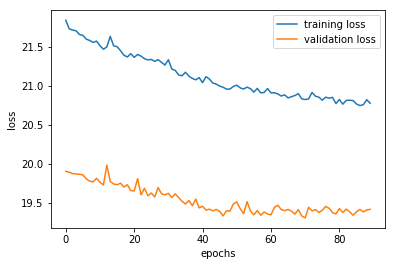

In [52]:
plt.plot(Autoencoder_history.history['loss'],label='training loss')
plt.plot(Autoencoder_history.history['val_loss'],label='validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

- The model may be further tuned and trained to reduce the loss function. However, our gaol is not to reduce the loss function defined, or to directly predict the features of continued playlists.
- Our goal is automatic playlist continuation. That is to say, given a playlist, we should find the best tracks from the existing pool of tracks that can add to the playlist.
- Ideally, we would like to train our Neural Network directly to achieve the task. However, the continuation of the playlists involves in sorting the tracks in the pool, of which the gradient descent does not exist and cannot be used to train the Neural Network.
- Thus, the evaluation metrics and the models for the task are discussed in the next section.

# Prediction model

## Metrics

- To continue the playlist, we compare the tracks from the pool of candidate tracks to the information of playlists, and take the closest tracks as the continued playlist prediction. 
- We use three metrics to evaluate the performance:
    - R-precision: # of matched recommended tracks divided by the number of continued playlist
    - Normalized discounted cumulative gain (NDCG): the ranking quality of the recommended tracks, increasing when matched tracks are placed higher in the list
    - Normalized recommended songs clicks (NRSC): # of refreshed (generate a new list of predict_K*20 tracks) needed before 90% of remaining tracks are recommended divided by the maximum possible # of clicks


In [53]:
tracks_pool_train = scaled_pl_train_array[:,input_K:,:,:].reshape([len(scaled_pl_train_array)*predict_K,len(feature_lists),1])
tracks_pool_test = scaled_pl_test_array[:,input_K:,:,:].reshape([len(scaled_pl_test_array)*predict_K,len(feature_lists),1])

max_d = predict_K+2

d_train = max_d*np.ones([len(tracks_pool_train), len(scaled_pl_train_array)])
for i in range(len(scaled_pl_train_array)):
    d_train[i*predict_K:(i+1)*predict_K,i] = np.arange(predict_K)
    
d_test = max_d*np.ones([len(tracks_pool_test), len(scaled_pl_test_array)])
for i in range(len(scaled_pl_test_array)):
    d_test[i*predict_K:(i+1)*predict_K,i] = np.arange(predict_K)

shuffle_idx = random.sample(range(len(tracks_pool_train)),len(tracks_pool_train))
tracks_pool_train = tracks_pool_train[shuffle_idx]
d_train = d_train[shuffle_idx]

shuffle_idx = random.sample(range(len(tracks_pool_test)),len(tracks_pool_test))
tracks_pool_test = tracks_pool_test[shuffle_idx]
d_test = d_test[shuffle_idx]


print(f'tracks pool shape {tracks_pool_test.shape}')
print(f'd_test shape {d_test.shape}')


tracks pool shape (6000, 113, 1)
d_test shape (6000, 200)


In [54]:
def Rprecision(d_true, d_pred, recommand_length=predict_K*20, max_d=max_d):
    # R-precision: # of matched recommended tracks divided by the number of remaining tracks
    
    if recommand_length > d_true.shape[0]:
        recommand_length = d_true.shape[0]
    
    sorted_idx = np.argsort(d_pred, axis=0)
    recommand_idx = sorted_idx[:recommand_length,:]

    Rp = []
    for pl in range(d_true.shape[1]):
        matched = d_true[recommand_idx[:,pl],pl] < max_d
        matched_num = np.sum(matched)
        total = d_true[:,pl] < max_d
        total_num = np.sum(total)
        total_num = np.max([1,total_num])
        Rp.append(matched_num/total_num)

    return np.array(Rp).mean()

def NDCG(d_true, d_pred, recommand_length=predict_K*20, max_d=max_d):
    # Normalized discounted cumulative gain (NDCG): the ranking quality of the recommended tracks, 
    # increasing when matched tracks are placed higher in the list
                
    if recommand_length > d_true.shape[0]:
        recommand_length = d_true.shape[0]
    
    sorted_idx = np.argsort(d_pred, axis=0)
    recommand_idx = sorted_idx[:recommand_length,:]
    
    ndcg = []
    for pl in range(d_true.shape[1]):
        dcg = d_true[recommand_idx[0,pl],pl] < max_d
        idcg = 1
        for i in range(1,recommand_length):
            dcg = dcg + (d_true[recommand_idx[i,pl],pl] < max_d)/np.log2(i+1)
            idcg = idcg + 1/np.log2(i+1)
        ndcg.append(dcg/idcg)
 
    return np.array(ndcg).mean()

def NormalizedRSC(d_true, d_pred, recommand_length=predict_K*20, max_d=max_d, stop_portion=0.9):
    # Recommended Songs clicks: # of refreshed needed before 90% of remaining tracks are recommended
    
    if recommand_length > d_true.shape[0]:
        recommand_length = d_true.shape[0]
    
    sorted_idx = np.argsort(d_pred, axis=0)
    max_click = int(np.ceil(d_true.shape[0]/recommand_length))
    
    normal_rsc = []
    for pl in range(d_true.shape[1]):
        click_i = 0
        for i in range(1,max_click+1):
            click_i = i-1
            clicked_recommand = i*recommand_length
            clicked_recommand_idx = sorted_idx[:clicked_recommand,pl]
            matched = d_true[clicked_recommand_idx,pl] < max_d
            matched_num = np.sum(matched)
            total = d_true[:,pl] < max_d
            total_num = np.sum(total)
            total_num = np.max([1,total_num])
            if matched_num >= total_num*stop_portion:
                normal_rsc.append(click_i/max_click)
                break
    
    return np.array(normal_rsc).mean()


## Models

### Average

- This is a basic model. We directly take the average of the features of a playlist, and compare the mean square distance between the averaged features tracks from the pool. The closest ones are the continued playlist prediction.  


In [55]:
pl_info_mean = np.mean(x_test,axis=1)

In [56]:
d_pred = []
for tr in tracks_pool_test.reshape([-1,len(feature_lists)]):
    tr_for_pl = []
    for pl in pl_info_mean.reshape([-1,len(feature_lists)]):
        tr_for_pl.append(np.mean((pl-tr)**2))
    d_pred.append(tr_for_pl)

In [57]:
Metrics = pd.DataFrame(
    [('average',Rprecision(d_test, d_pred), NDCG(d_test, d_pred), NormalizedRSC(d_test, d_pred))],
    columns=['Method','R-precision','NDCG','NRSC'])

### Track features compared to mean of autoencoder prediction
- Another model we try is to predict the continued playlist with autoencoder, take the mean of its features, and compare to the features of the tracks in the pool. 

In [59]:
pl_info_auto = np.mean(Autoencoder.predict(x_test).reshape([len(x_test),predict_K,len(feature_lists)]),axis=1)

In [60]:
d_pred = []
for tr in tracks_pool_test.reshape([-1,len(feature_lists)]):
    tr_for_pl = []
    for pl in pl_info_auto.reshape([-1,len(feature_lists)]):
        tr_for_pl.append(np.sum((pl-tr)**2))
    d_pred.append(tr_for_pl)

In [61]:
Metrics = Metrics.append(pd.DataFrame([('autoencoder prediction mean',Rprecision(d_test, d_pred), NDCG(d_test, d_pred), NormalizedRSC(d_test, d_pred))], columns=['Method','R-precision','NDCG','NRSC']))


### Prediction from repeated tracks compared to mean of autoencoder prediction
- Since the prediction of the continued playlist has been encoded and decoded, the information may be transformed to a different space. In order to capture the transformation information, we repeat the tracks from the pool (input_K) times and treat it as a new playlist. We then preform a prediction using this playlist of repeated tracks.
- The continued playlist prediction is made based on the difference of the prediction of the repeated track playlists and the predicted of the original playlists.

In [62]:
tr_info_auto = []
for tr in tracks_pool_test.reshape([-1,len(feature_lists)]):
    predicted_tr = Autoencoder.predict(tr.reshape([1,len(feature_lists)]).repeat(input_K,axis=0).reshape([1,input_K,len(feature_lists),1])).reshape([predict_K,len(feature_lists)])
    tr_info_auto.append(np.mean(predicted_tr,axis=0))
    

In [63]:
tr_info_auto = np.array(tr_info_auto)

In [64]:
d_pred = []
for tr in tr_info_auto.reshape([-1,len(feature_lists)]):
    tr_for_pl = []
    for pl in pl_info_auto.reshape([-1,len(feature_lists)]):
        tr_for_pl.append(np.sum((pl-tr)**2))
    d_pred.append(tr_for_pl)

In [65]:
Metrics = Metrics.append(pd.DataFrame([('predicted to predicted',Rprecision(d_test, d_pred), NDCG(d_test, d_pred), NormalizedRSC(d_test, d_pred))], columns=['Method','R-precision','NDCG','NRSC']))


### Encoded features compared to Encoded features

- Note that we have an encoded layer in our autoencoder which contains the concentrated information from the original playlists.
- Similar to the previous model, we make a repeated tracks playlist, while this time we extract the information from the encoded layer instead of the prediction. 

In [66]:
tr_info_auto = []
for tr in tracks_pool_test.reshape([-1,len(feature_lists)]):
    predicted_tr = Encoder.predict(tr.reshape([1,len(feature_lists)]).repeat(input_K,axis=0).reshape([1,input_K,len(feature_lists),1]))
    tr_info_auto.append(predicted_tr)
    

In [67]:
tr_info_auto = np.array(tr_info_auto).reshape([-1,len(feature_lists)])

In [68]:
pl_info_auto = Encoder.predict(x_test).reshape([len(x_test),len(feature_lists)])

In [69]:
d_pred = []
for tr in tr_info_auto:
    tr_for_pl = []
    for pl in pl_info_auto:
        tr_for_pl.append(np.sum((pl-tr)**2))
    d_pred.append(tr_for_pl)

In [70]:
Metrics = Metrics.append(pd.DataFrame([('Encoded to Encoded¶',Rprecision(d_test, d_pred), NDCG(d_test, d_pred), NormalizedRSC(d_test, d_pred))], columns=['Method','R-precision','NDCG','NRSC']))


## Results

- We found that the average method already achieve a fairly good result. This is not surprising as the tracks in each playlists should be similar in the feature space. 
- While, the predicted and encoded models perform even better, which means that the autoencoder extracts some useful information about the playlist through the process of encoding and decoding.
- Note that when we compare the original features to the predicted features, the performance is the worst. This implies that though we trained the autoencoder model based on the features from the raw playlists data, the decoded information has changed. This can be clearly showned in the visualization.

In [71]:
Metrics

,Method,R-precision,NDCG,NRSC
0,average,0.319167,0.024518,0.6905
0,autoencoder prediction mean,0.168333,0.010194,0.7495
0,predicted to predicted,0.424167,0.025147,0.5435
0,Encoded to Encoded¶,0.370500,0.023055,0.6060


# Visualization: MDS

- To better understand what is happening in the feature space, we would like to reduce the dimentionality to visualize in a 2D plot. 
- The method we choose is Multi-Dimensional Scaling, which can preserve the distance information between the data points.

In [72]:
plot_n = 10
plot_train_idx = random.sample(range(len(train_idx)),plot_n)
plot_test_idx = random.sample(range(len(test_idx)),plot_n)

y_train = scaled_pl_train_array[plot_train_idx].reshape([plot_n*tracks_per_playlist,len(feature_lists)])
y_test = scaled_pl_test_array[plot_test_idx].reshape([plot_n*tracks_per_playlist,len(feature_lists)])

embedding = MDS(n_components=2, n_jobs = -1)
MDS_pl_train = embedding.fit_transform(y_train)
print('[Result of Multi-Dimensional Scaling (MDS)]')
print(f'Shape of MDS_pl_train : {MDS_pl_train.shape}')

[Result of Multi-Dimensional Scaling (MDS)]
Shape of MDS_pl_train : (550, 2)


In [73]:
def plot_MDS_result(MDS_arg, pl_len, pl_n):
    '''
    Input
        MDS_arg : 2 dimensional feature spaces
        y_train_arg : label of each data point
        class_arg : list of class
    '''
    marker_list = ['.','o','^','^','<','>','1','2','3','4','8','s','p','P','*','+','x','X','D','d']
    
    fig, ax = plt.subplots(1, 1, figsize = (12, 12))
    
    cnt = 0
    for pl in range(pl_n):
        ax.scatter(MDS_arg[pl*pl_len:(pl+1)*pl_len, 0], MDS_arg[pl*pl_len:(pl+1)*pl_len, 1], 
                   s = 100, alpha = 0.75, edgecolors = 'k', linewidth = 1.5, marker = marker_list[cnt], 
                   label = 'Playlist ' + str(pl))
        cnt += 1
    
    # Update ticklabel size
    ax.tick_params(labelsize = 20)
    
    # Make labels
    ax.set_title(f'Visualization of {len(MDS_arg)} tracks in {pl_n} playlists using MDS', fontsize = 30)
    
    ax.set_xlabel('1st Feature', fontsize = 25)
    ax.set_ylabel('2nd Feature', fontsize = 25)
    ax.legend(bbox_to_anchor=(1, 1),loc='upper left', ncol = 1, fontsize = 20)

### Train set of original features

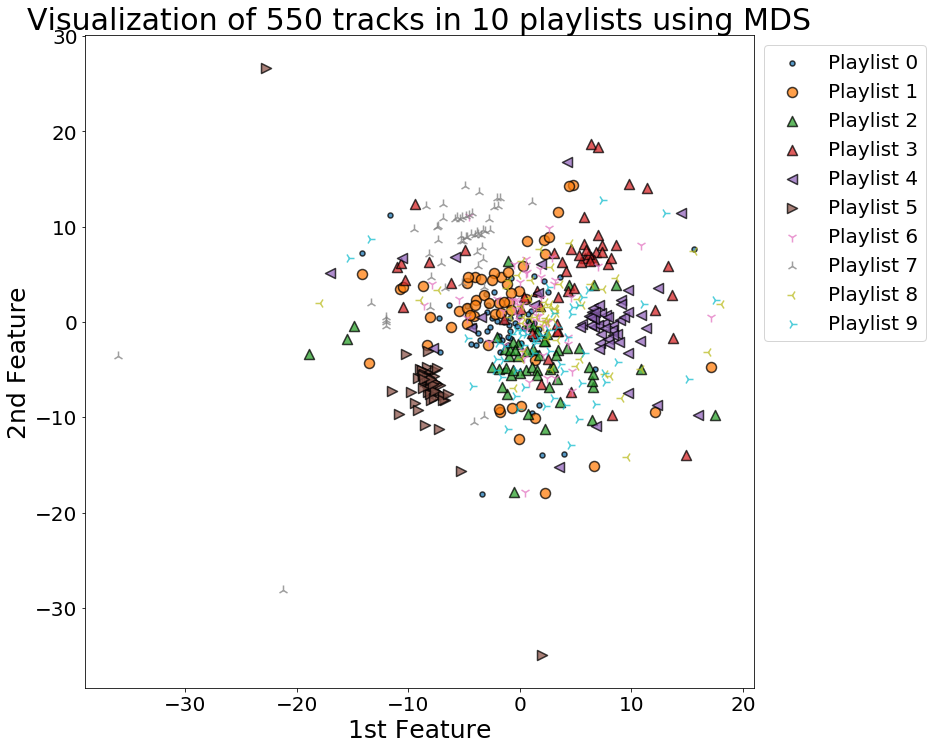

In [74]:
plot_MDS_result(MDS_pl_train, tracks_per_playlist, plot_n)

### Test set of original features

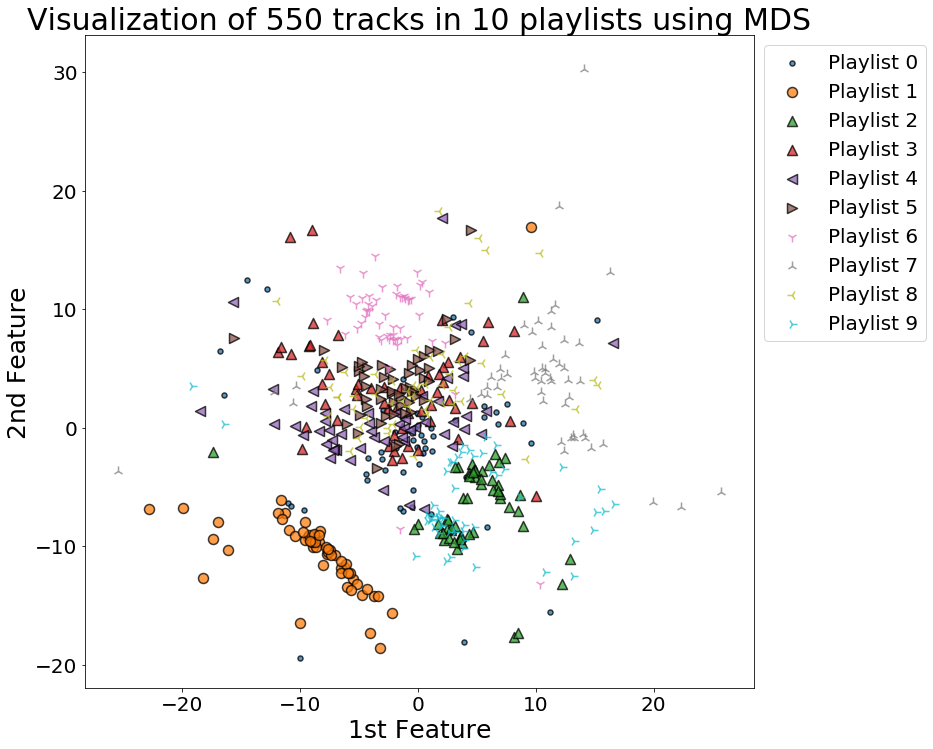

In [75]:
MDS_pl_test = embedding.fit_transform(y_test)
plot_MDS_result(MDS_pl_test, tracks_per_playlist, plot_n)

### Train set after autoencoder transformation

In [76]:
scaled_pl_train_array.shape

(800, 55, 113, 1)

In [77]:
y_train.shape

(550, 113)

In [78]:
y_train = scaled_pl_train_array[plot_train_idx,:input_K].reshape([plot_n*input_K,len(feature_lists)])
y_test = scaled_pl_test_array[plot_test_idx,:input_K].reshape([plot_n*input_K,len(feature_lists)])
y_train = np.float64(Autoencoder.predict(y_train.reshape([plot_n, input_K, len(feature_lists),1])).reshape([plot_n*predict_K,len(feature_lists)]))
y_test = np.float64(Autoencoder.predict(y_test.reshape([plot_n, input_K, len(feature_lists),1])).reshape([plot_n*predict_K,len(feature_lists)]))

embedding = MDS(n_components=2, n_jobs = -1)
MDS_pl_train = embedding.fit_transform(y_train)
print('[Result of Multi-Dimensional Scaling (MDS)]')
print(f'Shape of MDS_pl_train : {MDS_pl_train.shape}')

[Result of Multi-Dimensional Scaling (MDS)]
Shape of MDS_pl_train : (300, 2)


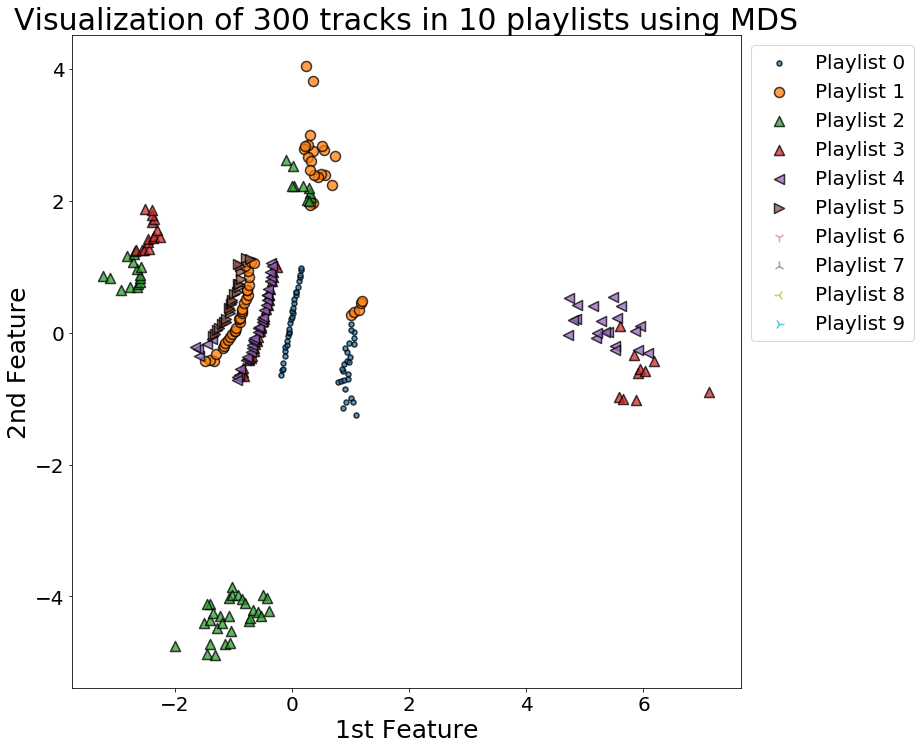

In [79]:
plot_MDS_result(MDS_pl_train, tracks_per_playlist, plot_n)

### Test set after autoencoder transformation

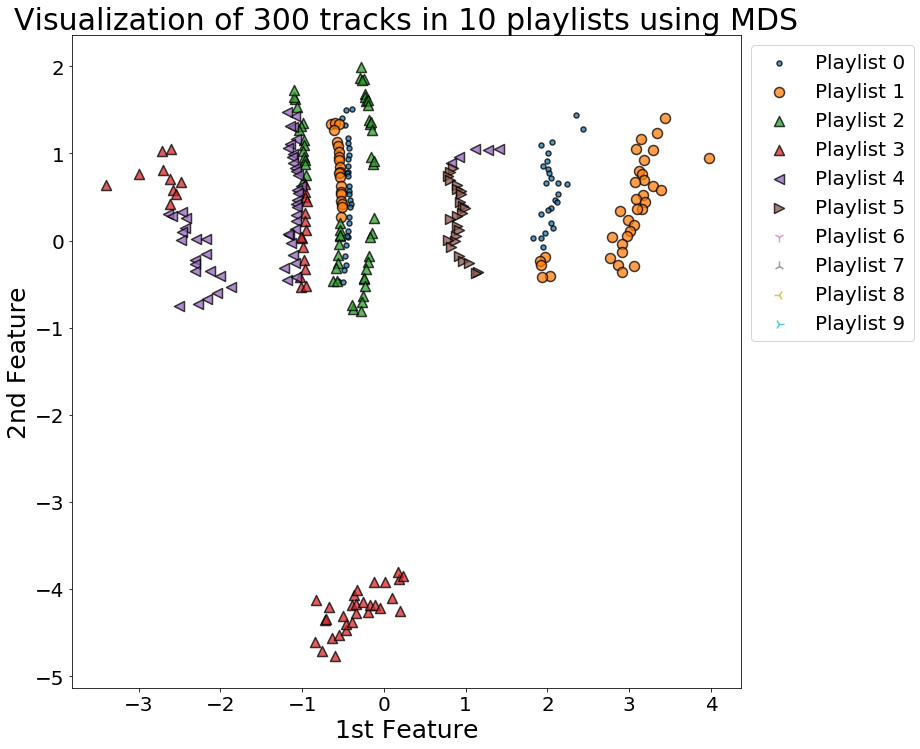

In [80]:
MDS_pl_test = embedding.fit_transform(y_test)
plot_MDS_result(MDS_pl_test, tracks_per_playlist, plot_n)

## Discussion
- We can see that in the original feature space, the tracks in the same playlist are closer to each other, while each playlist is also close to each other. 
- After the autoencoder transformation, surprisingly the playlists were seperated quite clearly.
